In [2]:
!pip install datasets

import tensorflow as tf

import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score,cross_val_predict
from sklearn.dummy import DummyClassifier
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00


## Functions:
For Colab to work, the mnist file needs to be uploaded to colab drive using the upload tool.

In [3]:
# Get the file. The full dataset. Place the mnist file in the same folder as
# the .py file
def load_data_set():
    data_file = os.path.join(os.path.dirname('/content/'), "mnist.csv")

    mnist_dataset = load_dataset("csv", data_files=data_file)
    mnist_dataset = mnist_dataset.shuffle(seed=42)  # shuffle the dataset
    # no. of unique labels: 10 unique labels
    output = len(np.unique(mnist_dataset['train']['label']))
    mnist_labels = mnist_dataset['train']['label']
    mnist_features = mnist_dataset['train'].remove_columns(['label'])

    return mnist_dataset, output, mnist_labels, mnist_features

def set_up_data_sets(dataset):
    r = dataset['train'].train_test_split(test_size=0.88095)
    train_set, test_set = r['train'], r['test']

    return r, train_set, test_set

def split_data_set(features, labels):
    #split the mnist dataset for the logistic regression and SVM models
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        labels, test_size=0.88095, random_state=42, shuffle=True)
    return X_train, X_test, y_train, y_test

def show_data_set(dataset):
    dataset.set_format(type="pandas")
    df = dataset['train'][:]
    return df

def reduced_show_data_set(dataset):
    dataset.set_format(type="pandas")
    df = dataset[:]
    return df

def run_digit_analysis(df):
    ax = df["label"].value_counts(ascending=True).plot.barh()

    for container in ax.containers:
        ax.bar_label(container)

    plt.title("Frequency of each hand-written number")

def print_results(model_description, y_pred, y_train, cv_score, score, precision, recall, f1, confusion):
    print()
    print("The results for the {}:".format(model_description))
    print('----------------')
    print("The cross validation result is:", cv_score)
    print("Estimated test labels: ", y_pred[:20])
    print("True test labels:      ", y_train[:20])
    print("The accuracy is:" ,score)
    print("The average precision is:", precision)
    print("The average recall is:", recall)
    print("The average f1-score is:", f1)
    print("The confusion matrix is: \n", confusion)

# base classifier for comparison
def base_classifier_run():
    description = 'most common baseline classifier'
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train, y_train)

    # Use 3-fold cross validation to evaluate the model
    cv_score = cross_val_score(dummy_clf, X_train, y_train, cv=3, scoring="accuracy")
    y_train_pred_multinomial = cross_val_predict(dummy_clf, X_train, y_train, cv=3)


    y_pred = dummy_clf.predict(X_train)

    confusion = confusion_matrix(y_train, y_pred)
    score = dummy_clf.score(X_train, y_train)

    #print(y_test)
    precision = precision_score(y_train, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_train, y_pred, average='weighted')
    f1 = f1_score(y_train, y_pred, average='weighted')

    print_results(description, y_pred, y_train, cv_score, score, precision, recall, f1, confusion)

    return dummy_clf, y_train_pred_multinomial

# Model design.
def logistic_classifier_run(description, C, X_train, y_train, X_test, y_test):

    model = LogisticRegression(penalty='l1', C=C, fit_intercept=True,
                               solver='saga', max_iter=10000, verbose=0, multi_class='multinomial')
    clf = model.fit(X_train, y_train)

    #beta = clf.coef_
    # Use 3-fold cross validation to evaluate the model
    cv_score = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
    y_train_pred_multinomial = cross_val_predict(clf, X_train, y_train, cv=3)


    y_pred = clf.predict(X_train) #(X_test)
    confusion = confusion_matrix(y_train, y_pred) #(y_test, y_pred)
    score = clf.score(X_train, y_train) #(X_test, y_test)

    precision = precision_score(y_train, y_pred, average='weighted') #(y_test, y_pred, average='weighted')
    recall = recall_score(y_train, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_train, y_pred, average='weighted')

    print_results(description, y_pred, y_train, cv_score, score, precision, recall, f1, confusion)

    return clf, y_train_pred_multinomial

# SVM Classifiers [Polynomial Kernel and Gaussian Kernel]
def poly_svm_classifier_run(description, C, degree, X_train, y_train, X_test, y_test):

    model = make_pipeline(StandardScaler(),
                          SVC(kernel="poly", degree=degree, coef0=1, C=C))

    polynomial_svm_clf = model.fit(X_train, y_train)


    # Use 3-fold cross validation to evaluate the model
    cv_score = cross_val_score(polynomial_svm_clf, X_train, y_train, cv=3, scoring="accuracy")
    y_train_pred_multinomial = cross_val_predict(polynomial_svm_clf, X_train, y_train, cv=3)


    y_pred = polynomial_svm_clf.predict(X_train) #(X_test)
    confusion = confusion_matrix(y_train, y_pred) #(y_test, y_pred)
    score = polynomial_svm_clf.score(X_train, y_train) #(X_test, y_test)

    precision = precision_score(y_train, y_pred, average='weighted') #(y_test, y_pred, average='weighted')
    recall = recall_score(y_train, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_train, y_pred, average='weighted')

    print_results(description, y_pred, y_train, cv_score, score, precision, recall, f1, confusion)

    return polynomial_svm_clf, y_train_pred_multinomial

def gauss_svm_classifier_run(description, C, gamma, X_train, y_train, X_test, y_test):

    model = make_pipeline(StandardScaler(),
                          SVC(kernel="rbf", gamma=gamma, C=C))

    gaussian_svm_clf = model.fit(X_train, y_train)


    # Use 3-fold cross validation to evaluate the model
    cv_score = cross_val_score(gaussian_svm_clf, X_train, y_train, cv=3, scoring="accuracy")
    y_train_pred_multinomial = cross_val_predict(gaussian_svm_clf, X_train, y_train, cv=3)


    y_pred = gaussian_svm_clf.predict(X_train) #(X_test)
    confusion = confusion_matrix(y_train, y_pred) #(y_test, y_pred)
    score = gaussian_svm_clf.score(X_train, y_train) #(X_test, y_test)

    precision = precision_score(y_train, y_pred, average='weighted') #(y_test, y_pred, average='weighted')
    recall = recall_score(y_train, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_train, y_pred, average='weighted')

    print_results(description, y_pred, y_train, cv_score, score, precision, recall, f1, confusion)

    return gaussian_svm_clf, y_train_pred_multinomial

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

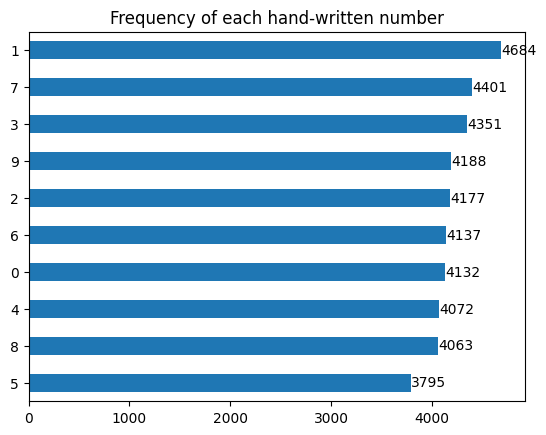

In [4]:
#generate the datasets to be used for training
mnist_dataset, output, mnist_labels, mnist_features = load_data_set()
r, train_set, test_set = set_up_data_sets(mnist_dataset) # this isn't necessary

df = show_data_set(mnist_dataset)
mnist_features = reduced_show_data_set(mnist_features)
mnist_features = mnist_features.values.tolist()
X_train, X_test, y_train, y_test = split_data_set(mnist_features, mnist_labels)


# plot the frequency of each hand-written digit (1 is the most frequent)
run_digit_analysis(df)


In [5]:
mnist_dataset.shape

{'train': (42000, 785)}

### A. Use a dummy classifier for comparison purposes

In [ ]:
base_clf, base_cv = base_classifier_run()


The results for the most common baseline classifier:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]


### B. Classify Using Logistic Regression:
Set regularization parameter C.
Smaller values of C constrain the model more. In the L1 penalty case, this leads to sparser solutions.
1 is the default value for C.

In [ ]:
l1_clf_0_01, l1_cv_0_01 = logistic_classifier_run('Logistic regression', 0.01, X_train, y_train, X_test, y_test)


The results for the Logistic regression:
----------------
The cross validation result is: [0.87042591 0.8830234  0.8847539 ]
Estimated test labels:  [9 5 3 1 1 2 1 8 8 3 6 5 2 7 2 0 2 2 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.993
The average precision is: 0.9930051107881731
The average recall is: 0.993
The average f1-score is: 0.99300176145198
The confusion matrix is: 
 [[458   0   0   0   0   0   0   0   0   0]
 [  0 565   0   0   0   1   0   0   0   0]
 [  0   0 498   0   1   0   0   0   1   0]
 [  0   0   1 518   0   0   0   0   2   2]
 [  0   0   0   0 485   0   0   0   0   5]
 [  0   0   0   2   1 480   0   0   0   0]
 [  0   0   0   0   0   0 512   0   0   0]
 [  0   0   0   0   0   0   0 476   0   3]
 [  0   0   1   1   0   1   0   0 488   2]
 [  1   0   0   3   3   1   0   3   0 485]]
/


In [12]:
y_pred_0_01 = l1_clf_0_01.predict(X_test)

confusion = confusion_matrix(y_test,y_pred_0_01)

print("Estimated test labels: ", y_pred_0_01)
print("True test labels:      ", y_test)
print("The confusion matrix is: \n", confusion)


print("The accuracy is:" , l1_clf_0_01.score(X_test, y_test))

Estimated test labels:  [5 0 9 ... 4 1 7]
True test labels:       [5, 0, 9, 6, 7, 5, 2, 3, 3, 9, 4, 9, 2, 8, 0, 4, 9, 6, 6, 9, 9, 8, 6, 0, 1, 5, 7, 2, 0, 4, 5, 9, 2, 6, 5, 7, 3, 0, 4, 3, 4, 4, 3, 1, 3, 5, 8, 8, 6, 9, 6, 9, 4, 7, 6, 6, 1, 3, 4, 8, 3, 4, 8, 8, 0, 2, 6, 4, 0, 4, 7, 6, 7, 5, 3, 2, 7, 5, 5, 6, 9, 7, 2, 2, 5, 0, 1, 0, 4, 8, 8, 2, 0, 2, 4, 3, 8, 6, 0, 9, 1, 5, 5, 0, 2, 0, 5, 0, 8, 7, 3, 5, 0, 9, 9, 9, 8, 7, 5, 0, 8, 7, 6, 9, 2, 7, 1, 2, 4, 4, 6, 5, 2, 0, 1, 4, 1, 0, 8, 5, 6, 9, 9, 6, 0, 0, 5, 5, 0, 8, 5, 9, 4, 9, 9, 1, 8, 2, 8, 2, 3, 4, 3, 1, 6, 1, 3, 0, 9, 1, 5, 0, 1, 1, 1, 1, 1, 5, 8, 9, 4, 0, 5, 3, 4, 3, 9, 5, 9, 0, 5, 0, 0, 3, 7, 1, 1, 6, 2, 9, 1, 0, 6, 0, 3, 1, 2, 9, 4, 7, 8, 6, 3, 4, 6, 3, 1, 9, 5, 5, 8, 6, 4, 1, 0, 3, 5, 7, 5, 7, 8, 6, 7, 8, 1, 8, 6, 8, 5, 0, 9, 8, 0, 3, 7, 5, 7, 2, 1, 5, 5, 7, 5, 1, 6, 4, 2, 9, 0, 9, 6, 0, 1, 0, 8, 2, 4, 5, 4, 2, 6, 2, 9, 1, 2, 6, 4, 9, 5, 4, 0, 5, 1, 6, 2, 7, 0, 4, 2, 0, 9, 3, 9, 0, 2, 2, 1, 5, 8, 8, 0, 1, 8, 3, 7, 7, 6, 2, 4, 2, 4, 

In [ ]:
l1_clf_0_1, l1_cv_0_1 = logistic_classifier_run('Logistic regression', 0.1, X_train, y_train, X_test, y_test)

In [ ]:
l1_clf_1, l1_cv_1 = logistic_classifier_run('Logistic regression', 1.0, X_train, y_train, X_test, y_test)

### C. Running the Polynomial and Gaussian SVM models:
I used a grid search to locate the ideal parameters. I did many runs, so you can ignore the weaker results.

### C.1: Polynomial SVM

In [9]:
degree = [3, 5, 10]
C = [1, 3, 5, 10]

for d in degree:
  for c in C:
    print("Combination: ", [d, c])
    poly_clf, poly_cv = poly_svm_classifier_run('Polynomial SVM', c, d, X_train, y_train, X_test, y_test)


Combination:  [3, 1]

The results for the Polynomial SVM:
----------------
The cross validation result is: [0.92861428 0.94661068 0.94837935]
Estimated test labels:  [9 5 3 1 1 2 1 8 8 3 6 5 2 7 2 0 2 2 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.9972
The average precision is: 0.9972048016565861
The average recall is: 0.9972
The average f1-score is: 0.9972002222210437
The confusion matrix is: 
 [[457   0   0   0   0   0   1   0   0   0]
 [  0 565   0   0   0   0   0   0   1   0]
 [  0   0 500   0   0   0   0   0   0   0]
 [  0   0   0 520   0   0   0   0   3   0]
 [  0   0   0   0 489   0   0   0   0   1]
 [  0   0   0   0   0 483   0   0   0   0]
 [  0   0   0   0   0   0 512   0   0   0]
 [  0   0   0   0   0   0   0 477   0   2]
 [  0   2   0   0   0   0   0   0 491   0]
 [  2   0   0   0   2   0   0   0   0 492]]
Combination:  [3, 3]

The results for the Polynomial SVM:
----------------
The cross validation result is:

### C.2: Gaussian SVM

In [7]:
gamma = [0.001] #this is the ideal value for gamma. The full grid search can be found below.
C = [0.5, 3, 5, 7, 10]

for g in gamma:
  for c in C:
    print('combination: ', [g, c])
    gauss_clf, gauss_cv = gauss_svm_classifier_run('Gaussain SVM', c, g, X_train, y_train, X_test, y_test)

combination:  [0.001, 0.5]

The results for the Gaussain SVM:
----------------
The cross validation result is: [0.89262148 0.91841632 0.89435774]
Estimated test labels:  [9 5 3 1 1 2 1 8 8 2 6 5 2 7 2 0 8 2 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.9482
The average precision is: 0.948164123941916
The average recall is: 0.9482
The average f1-score is: 0.94808595713377
The confusion matrix is: 
 [[449   0   2   0   0   2   4   0   1   0]
 [  0 554   5   1   0   3   1   0   2   0]
 [  2   2 477   2   5   0   2   1   8   1]
 [  0   3   7 491   1   8   0   4   6   3]
 [  0   1   9   0 464   0   1   1   0  14]
 [  4   2   2   5   1 457   9   0   2   1]
 [  2   1   0   0   1   5 501   0   2   0]
 [  1   2   0   0   2   0   0 455   1  18]
 [  1   9   9   4   2   7   1   1 453   6]
 [  3   2   8  11  15   0   0  15   2 440]]
combination:  [0.001, 3]

The results for the Gaussain SVM:
----------------
The cross validation result 

In [6]:
gamma = [0.001, 0.01, 0.05] #more options for gamma. I did higher values too which be found viewed below
C = [0.01, 0.1, 0.5, 1, 3]

for g in gamma:
  for c in C:
    print('combination: ', [g, c])
    gauss_clf, gauss_cv = gauss_svm_classifier_run('Gaussain SVM', c, g, X_train, y_train, X_test, y_test)

combination:  [0.001, 0.01]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.15656869 0.14877025 0.15606242]
Estimated test labels:  [6 3 3 1 1 1 1 1 3 3 6 3 3 3 3 0 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.3334
The average precision is: 0.4706726213585467
The average recall is: 0.3334
The average f1-score is: 0.25150690644400264
The confusion matrix is: 
 [[104   7   0 342   0   0   5   0   0   0]
 [  0 557   0   8   0   0   1   0   0   0]
 [  0  86   5 404   0   0   5   0   0   0]
 [  0  78   0 445   0   0   0   0   0   0]
 [  0 124   0 220   4   0  62   0   0  80]
 [  0 129   0 352   0   0   1   0   0   1]
 [  0  58   0 135   0   0 319   0   0   0]
 [  0 116   1 272   0   0   0   0   0  90]
 [  0 223   0 264   0   0   0   0   0   6]
 [  0  87   0 163   0   0  13   0   0 233]]
combination:  [0.001, 0.1]

The results for the Gaussain SVM:
----------------
The cross validation result is: [0.83323335 0.854

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.01, 0.1]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.21955609 0.21535693 0.22569028]
Estimated test labels:  [3 3 3 1 1 3 1 3 3 3 3 3 3 3 3 3 3 3 3 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.3408
The average precision is: 0.6966288199439773
The average recall is: 0.3408
The average f1-score is: 0.33316820702943534
The confusion matrix is: 
 [[ 14   0   0 444   0   0   0   0   0   0]
 [  0 511   0  55   0   0   0   0   0   0]
 [  0   0   0 500   0   0   0   0   0   0]
 [  0   0   0 523   0   0   0   0   0   0]
 [  0   2   0 347 124   0   0   0   0  17]
 [  0   0   0 483   0   0   0   0   0   0]
 [  0   1   0 296   0   0 215   0   0   0]
 [  0   1   0 407   0   0   0  58   0  13]
 [  0   7   0 431   0   0   0   0  55   0]
 [  0   0   0 290   2   0   0   0   0 204]]
combination:  [0.01, 0.5]

The results for the Gaussain SVM:
----------------
The cross validation result is: [0.5794841  0.5716

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.05, 0.1]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.05, 0.5]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.17036593 0.17096581 0.16446579]
Estimated test labels:  [3 3 3 1 1 3 1 3 3 3 3 3 3 3 3 3 3 3 3 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.207
The average precision is: 0.4227893493761141
The average recall is: 0.207
The average f1-score is: 0.13632023795773404
The confusion matrix is: 
 [[  0   0   0 458   0   0   0   0   0   0]
 [  0 487   0  79   0   0   0   0   0   0]
 [  0   0   0 500   0   0   0   0   0   0]
 [  0   0   0 523   0   0   0   0   0   0]
 [  0   0   0 490   0   0   0   0   0   0]
 [  0   0   0 483   0   0   0   0   0   0]
 [  0   0   0 505   0   0   7   0   0   0]
 [  0   0   0 476   0   0   0   3   0   0]
 [  0   0   0 493   0   0   0   0   0   0]
 [  0   0   0 481   0   0   0   0   0  15]]
combination:  [0.05, 1]

The results for the Gaussain SVM:
----------------
The cross validation result is: [0.19376125 0.18956209

In [21]:
C = [0.01, 0.1, 0.5, 1, 3, 5] #more options for gamma but most don't really work. Ignore
gamma = [0.1, 1, 2, 4, 5, 10]

for c in C:
  for g in gamma:
    print('combination: ', [c, g])
    gauss_clf, gauss_cv = gauss_svm_classifier_run('Gaussain SVM', c, g, X_train, y_train, X_test, y_test)

combination:  [0.01, 0.1]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.01, 1]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.01, 2]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.01, 4]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.01, 5]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.01, 10]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.1, 0.1]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.1, 1]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.1, 2]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.1, 4]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.1, 5]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.1, 10]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.5, 0.1]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 3 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.2178
The average precision is: 0.11891119052937235
The average recall is: 0.2178
The average f1-score is: 0.13000995439222685
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0   0   0 523   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.5, 1]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.5, 2]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.5, 4]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.5, 5]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [0.5, 10]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The results for the Gaussain SVM:
----------------
The cross validation result is: [0.11337732 0.11277744 0.11344538]
Estimated test labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True test labels:       [9, 5, 3, 1, 1, 2, 1, 8, 8, 3, 6, 5, 2, 7, 2, 0, 2, 2, 1, 1]
The accuracy is: 0.1132
The average precision is: 0.012814239999999998
The average recall is: 0.1132
The average f1-score is: 0.023022349982033775
The confusion matrix is: 
 [[  0 458   0   0   0   0   0   0   0   0]
 [  0 566   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0 523   0   0   0   0   0   0   0   0]
 [  0 490   0   0   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   0   0   0]
 [  0 512   0   0   0   0   0   0   0   0]
 [  0 479   0   0   0   0   0   0   0   0]
 [  0 493   0   0   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0   0   0   0]]
combination:  [1, 0.1]

The results for the Gaussain SVM:
----------------
The cross validation result is: [0.18116377 0.1799

KeyboardInterrupt: ignored